# RESUME CLASSIFICATION

## Installations

In [1]:
# !pip install nltk pandas scikit-learn
# !pip install wordcloud
# !pip install textblob
# !pip install xgboost

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
import re
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import joblib

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Farah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Farah\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Farah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load & Understand the Data

In [3]:
df = pd.read_csv('resume_cleandataset_labeled.csv')

In [4]:
df.sample(5)

,filename,content,ext,role
21,Sri Krishna S_Hexaware.doc,Workday Integration Consultant\n\nName ...,doc,Workday Consultant
31,RameshP_Hexaware.docx,Ramesh A\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,docx,Workday Consultant
48,React Developer_Sarala Madasu-converted.docx," 204,Sri geethika prestige,road number 10,ban...",docx,React Developer
27,Naresh Babu Cherukuri_Hexaware.doc,Name : Naresh Babu Cherukuri\n\n\nObjective:\...,doc,Workday Consultant
57,React Developer_Thirupathiamma.docx,Thirupathamma Balla SUMMARY: 2.8 year of IT ...,docx,React Developer


In [5]:
df.shape

(79, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  79 non-null     object
 1   content   79 non-null     object
 2   ext       79 non-null     object
 3   role      79 non-null     object
dtypes: object(4)
memory usage: 2.6+ KB


## Data Cleaning
##### Remove rows where content is NaN
##### Remove duplicate rows in content
##### Reset index

In [7]:
def clean_dataframe(df, subset_col="content"):
    df = df.dropna(subset=[subset_col])
    df = df.drop_duplicates(subset=[subset_col], keep="first")
    df = df.reset_index(drop=True)
    
    return df

In [8]:
df = clean_dataframe(df, subset_col="content")

In [9]:
df.isnull().sum()

filename    0
content     0
ext         0
role        0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
#OBSERVATIONS
"""
The dataset contains 79 observations across 4 features, with no duplicate or missing values present.
"""

'\nThe dataset contains 79 observations across 4 features, with no duplicate or missing values present.\n'

## Feature Transformation with Label encoding of Target feature

In [12]:
LE=LabelEncoder()
Y_encoded=LE.fit_transform(df["role"])
df["role"]=Y_encoded
y=df["role"]

## EDA

In [13]:
df["role"].value_counts()

role
1    24
3    21
0    20
2    14
Name: count, dtype: int64

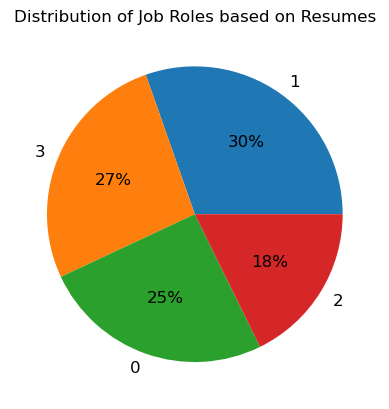

In [14]:
plt.pie(df["role"].value_counts(),
        labels=df["role"].value_counts().index,
        autopct="%.0f%%",
         textprops={'fontsize': 12}
       )
plt.title("Distribution of Job Roles based on Resumes")
plt.show()

In [15]:
#OBSERVATION
"""
The target variable role is a multiclass feature comprising four distinct classes.
The distribution is not significantly imbalanced - the largest class contains 24 samples, which is only 1.7 times the smallest class with 14 samples.
In most NLP classification tasks, such a minor imbalance is considered acceptable and typically does not require oversampling or class balancing.
"""

'\nThe target variable role is a multiclass feature comprising four distinct classes.\nThe distribution is not significantly imbalanced - the largest class contains 24 samples, which is only 1.7 times the smallest class with 14 samples.\nIn most NLP classification tasks, such a minor imbalance is considered acceptable and typically does not require oversampling or class balancing.\n'

In [16]:
# Creating custom features
"""
I have engineered custom features based on resume's extracted content to extract the number of characters, words, and sentences for each observation.
"""

"\nI have engineered custom features based on resume's extracted content to extract the number of characters, words, and sentences for each observation.\n"

In [17]:
#Number of characters
df["num_characters"]=df["content"].apply(len)

In [18]:
#Number of words
df["num_words"]=df["content"].apply(lambda x:len(nltk.word_tokenize(x)))

In [19]:
#Number of sentences
df["num_sentences"]=df["content"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [20]:
df.sample(2)

,filename,content,ext,role,num_characters,num_words,num_sentences
0,Peoplesoft Finance_Pritam Biswas.doc,|Personal Details ...,doc,0,11323,1191,51
31,RameshP_Hexaware.docx,Ramesh A\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,docx,3,5379,830,51


In [21]:
df[["num_characters","num_words","num_sentences"]].describe().astype(float).round(2)

,num_characters,num_words,num_sentences
count,79.00,79.00,79.00
mean,5883.44,839.01,41.22
std,5033.95,553.05,26.67
min,992.00,152.00,3.00
25%,2931.00,451.50,25.00
50%,4048.00,660.00,35.00
75%,7250.00,1095.50,52.50
max,35170.00,3045.00,171.00


### Histogram

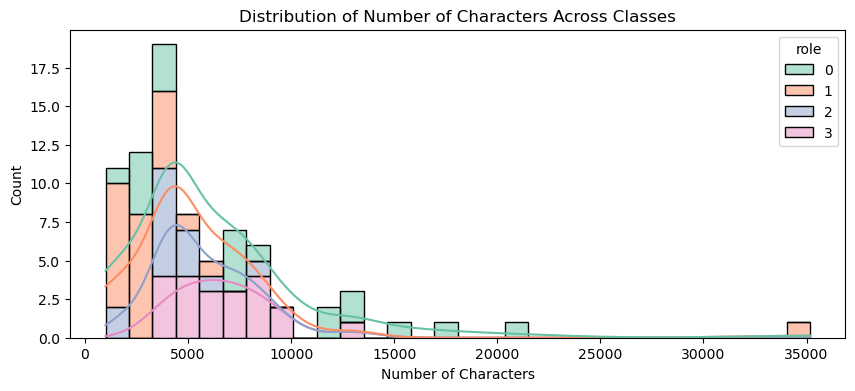

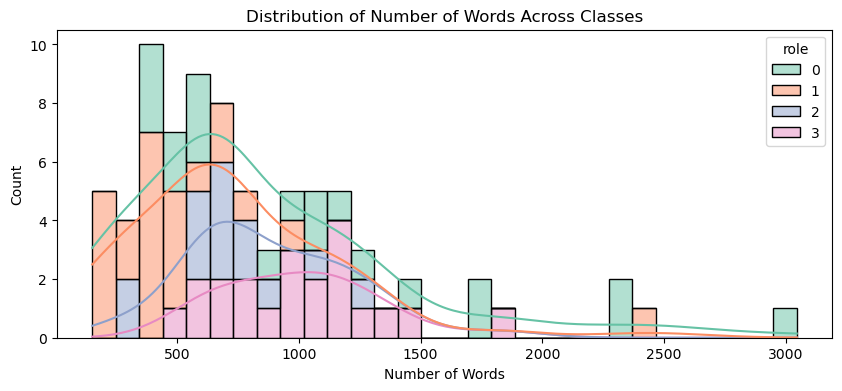

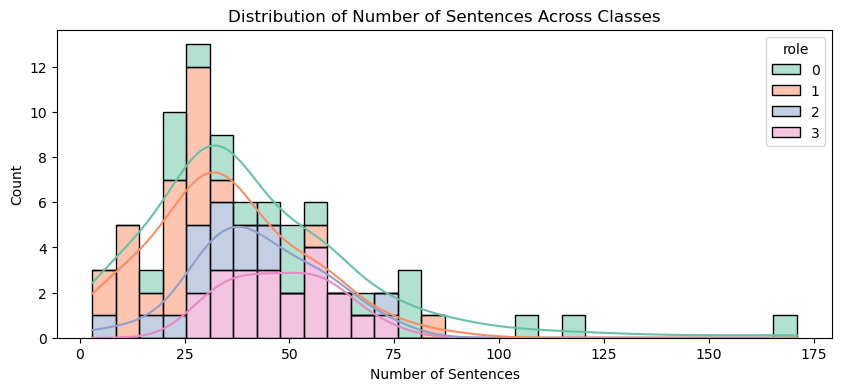

In [22]:
#histograms to see how  num_characters, num_words and num_sentences vary across different target classes.
features = [
    ('num_characters', 'Number of Characters'),
    ('num_words', 'Number of Words'),
    ('num_sentences', 'Number of Sentences')
]

for col, label in features:    #col gets the first item -'num_characters' and label gets the second item - 'Number of Characters'
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='role', bins=30, kde=True,palette='Set2', multiple='stack')
    plt.title(f"Distribution of {label} Across Classes")
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.show()

### Pairplot

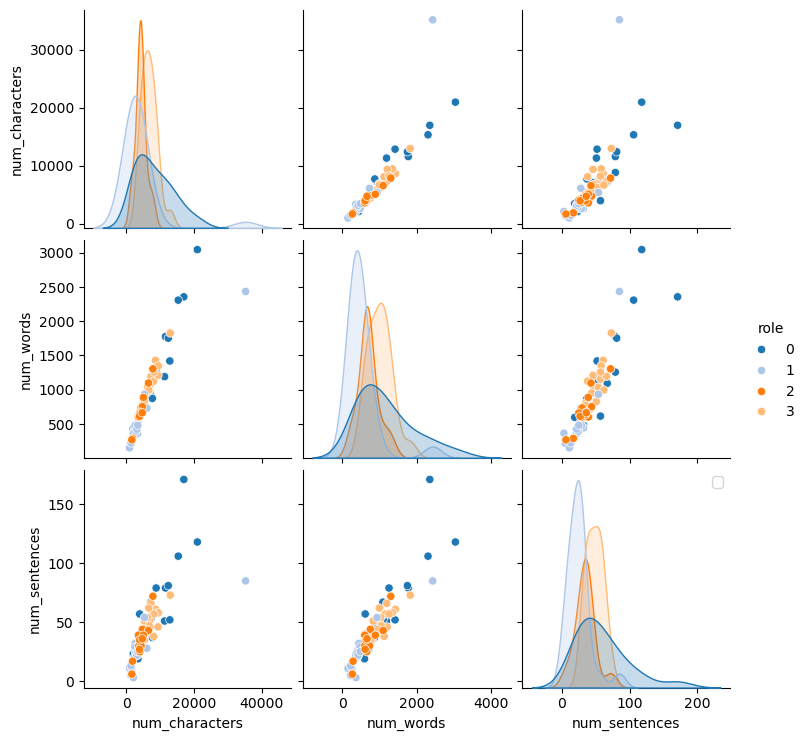

In [23]:
warnings.filterwarnings("ignore")
palette = sns.color_palette("tab20", 20)
sns.pairplot(df[["num_characters", "num_words", "num_sentences", "role"]], hue="role", palette=palette)
plt.legend()
plt.show()

### Correlation

In [24]:
df[["num_characters", "num_words", "num_sentences", "role"]].corr()

,num_characters,num_words,num_sentences,role
num_characters,1.000000,0.911902,0.779090,-0.074938
num_words,0.911902,1.000000,0.911707,-0.028710
num_sentences,0.779090,0.911707,1.000000,-0.071085
role,-0.074938,-0.028710,-0.071085,1.000000


<Axes: >

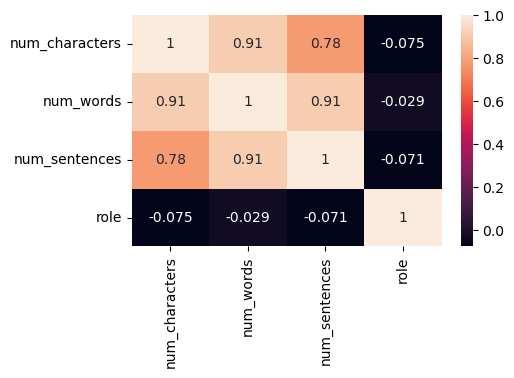

In [25]:
plt.figure(figsize=(5,3))
sns.heatmap(df[["num_characters", "num_words", "num_sentences", "role"]].corr(), annot=True)

In [26]:
#OBSERVATION
"""
The custom features num_characters, num_words, and num_sentences show high correlation with each other (above 0.9), meaning they carry similar
information. While this multicollinearity can affect linear models, it’s usually not a major issue in classification tasks, especially when combined
with strong features like TF-IDF or Bag of Words.

These features have a very weak correlation (less than 0.1) with the target variable role. So, on their own, they are not likely to improve model
accuracy much, but they may still be helpful as additional features in ensemble models or for basic data analysis and readability insights.
"""

'\nThe custom features num_characters, num_words, and num_sentences show high correlation with each other (above 0.9), meaning they carry similar\ninformation. While this multicollinearity can affect linear models, it’s usually not a major issue in classification tasks, especially when combined\nwith strong features like TF-IDF or Bag of Words.\n\nThese features have a very weak correlation (less than 0.1) with the target variable role. So, on their own, they are not likely to improve model\naccuracy much, but they may still be helpful as additional features in ensemble models or for basic data analysis and readability insights.\n'

## Data Preprocessing
##### Convert text to lowercase
##### Tokenize text into individual words
##### Remove special characters and punctuation
##### Eliminate stopwords 
##### Apply stemming to reduce words to their base form

In [27]:
"""
Data preprocessing is a crucial step in Natural Language Processing (NLP) that prepares raw text data for analysis or modeling. It helps clean,
standardize, and simplify the text, enabling algorithms to better understand and extract meaningful patterns.

Key Steps:
- Lowercasing: Converts all text to lowercase to avoid treating words like "The" and "the" differently.
- Tokenization: Splits text into individual units (tokens), such as words or phrases, making it easier to process and analyze.
- Removing Special Characters and Punctuation : Eliminates punctuation, symbols, or sometimes digits that usually don’t add value in most NLP tasks.
- Removing Stopwords: Removes common words (e.g., "is", "the", "and") that don't carry significant meaning and clutter the data.
- Stemming: Reduces words to their root form (e.g., “running” → “run”), helping group similar words and reduce dimensionality.

These steps help transform unstructured text into a clean, standardized format suitable for machine learning models.
"""

'\nData preprocessing is a crucial step in Natural Language Processing (NLP) that prepares raw text data for analysis or modeling. It helps clean,\nstandardize, and simplify the text, enabling algorithms to better understand and extract meaningful patterns.\n\nKey Steps:\n- Lowercasing: Converts all text to lowercase to avoid treating words like "The" and "the" differently.\n- Tokenization: Splits text into individual units (tokens), such as words or phrases, making it easier to process and analyze.\n- Removing Special Characters and Punctuation : Eliminates punctuation, symbols, or sometimes digits that usually don’t add value in most NLP tasks.\n- Removing Stopwords: Removes common words (e.g., "is", "the", "and") that don\'t carry significant meaning and clutter the data.\n- Stemming: Reduces words to their root form (e.g., “running” → “run”), helping group similar words and reduce dimensionality.\n\nThese steps help transform unstructured text into a clean, standardized format suit

In [28]:
# The transform_text function encapsulates all the data preprocessing steps required to clean the text data.
stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

def transform_text(text):
    # If text is a list or Series, apply preprocessing to each document
    if isinstance(text, (list, pd.Series)):
        return [transform_text(doc) for doc in text]
    
    # For a single string
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    filtered = [
        ps.stem(word)
        for word in tokens
        if word.isalnum() and word not in stop_words
    ]
    return " ".join(filtered)

In [29]:
df["transformed_data"]=df["content"].apply(transform_text)

In [30]:
df.head(2)

,filename,content,ext,role,num_characters,num_words,num_sentences,transformed_data
0,Peoplesoft Finance_Pritam Biswas.doc,|Personal Details ...,doc,0,11323,1191,51,detail biswa birth locat experi summari experi...
1,Peoplesoft Admin_Vinod Akkala.doc,Vinod Akkala\nPeopleSoft DBA Admin.\n\n\nProfe...,doc,0,16981,2356,171,vinod akkala peoplesoft dba admin profession s...


### Word Cloud

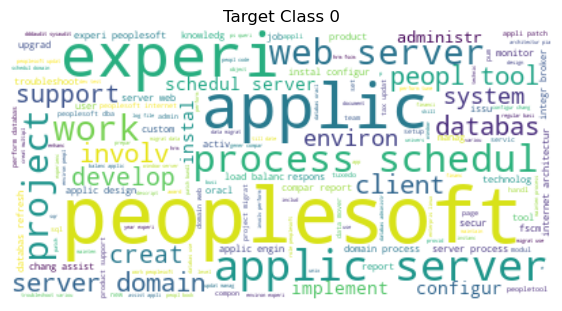

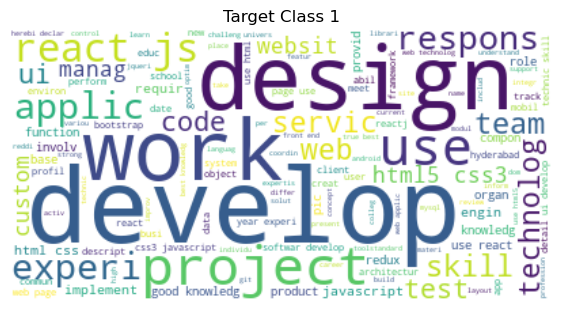

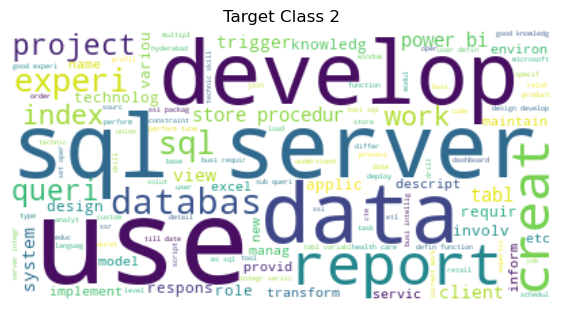

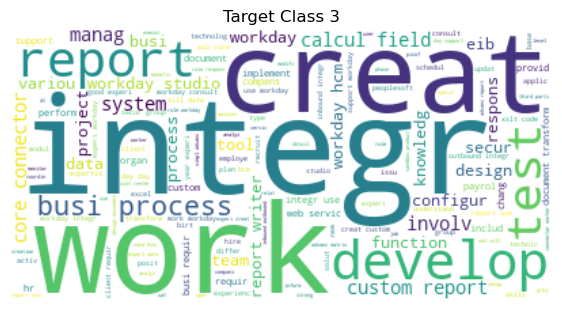

In [31]:
#Group clsses by Sentiment
grouped = df.groupby('role')['transformed_data'].apply(lambda x: " ".join(x))

#Generate a word cloud per role classes (Peoplesoft Consultant - 0, React Developer - 1, SQL Developer - 2 Worday Consultant - 3)

for label, text in grouped.items():
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Target Class {label}")
    plt.show()

In [32]:
from collections import Counter

top_words_per_class = df.groupby('role')['transformed_data'].apply(
    lambda x: Counter(" ".join(x).split()).most_common(10)
)

# Display results
for role, word_list in top_words_per_class.items():
    print(f"\nTop 10 words for Role category '{role}':")
    for word, freq in word_list:
        print(f"{word}: {freq}")


Top 10 words for Role category '0':
server: 378
peoplesoft: 371
applic: 350
experi: 225
databas: 195
process: 156
configur: 140
report: 130
instal: 128
environ: 125

Top 10 words for Role category '1':
develop: 152
use: 122
react: 104
experi: 91
design: 89
js: 85
work: 85
project: 82
web: 69
applic: 69

Top 10 words for Role category '2':
sql: 175
data: 112
develop: 106
use: 103
experi: 98
server: 97
report: 86
tabl: 75
function: 65
creat: 65

Top 10 words for Role category '3':
workday: 377
report: 322
integr: 295
work: 223
creat: 183
busi: 180
use: 172
experi: 165
develop: 140
test: 136


## Model Performance Comparison: BoW vs TF-IDF

In [34]:
# Evaluation function
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n => {model_name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    classes = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print("Confusion Matrix:")
    print(cm)
### ---------------------------------------------------------------------------------------------------------------###
#  Vectorizers for comparison
vectorizers = {
    "BoW": CountVectorizer(max_features=3000, ngram_range=(1, 2)),
    "TF-IDF": TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
}

#  Model list
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(),
    "SGDClassifier": SGDClassifier(loss='hinge', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

#  Split the raw text data before vectorization
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['transformed_data'], y, test_size=0.2, stratify=y, random_state=42)

# Evaluate each vectorizer + model combination
for vect_name, vectorizer in vectorizers.items():
    print(f"\n\n====== {vect_name} Vectorizer ======")

    # Fit vectorizer only on training data
    X_train = vectorizer.fit_transform(X_train_raw)
    X_test = vectorizer.transform(X_test_raw)

    # Train and evaluate all models
    for model_name, model in models.items():
        evaluate_model(model, f"{vect_name} + {model_name}", X_train, X_test, y_train, y_test)




====== BoW Vectorizer ======

 => BoW + MultinomialNB Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Confusion Matrix:
[[4 0 0 0]
 [0 5 0 0]
 [0 0 3 0]
 [0 0 0 4]]

 => BoW + LogisticRegression Accuracy: 0.8750
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.71      1.00      0.83         5
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         4

    accuracy                           0.88        16
   macro

In [ ]:
"""
# Recommended to  use MultinomialNB, LogisticRegression, LinearSVC, and SGDClassifier because:
# 1. Text data (TF-IDF/BoW) is high-dimensional and sparse. Linear models handle this efficiently.
# 2. Naive Bayes (MultinomialNB) is a strong baseline for word frequency-based features.
# 3. LogisticRegression and LinearSVC provide robust performance for linearly separable text data.
# 4. SGDClassifier is useful for large datasets with hinge loss (SVM-like) optimization.
#
#  Not recommended to use tree based models like  Random Forest / XGBoost?
# - Tree-based models are inefficient with sparse, high-dimensional data (require dense conversion, high memory).
# - Training becomes slow and provides no significant performance advantage for TF-IDF vectors.
# - Such models work better with dense embeddings (Word2Vec, BERT), not sparse TF-IDF.
"""

### Cross-Validation with TF-IDF

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define pipelines for 4 models
pipelines = {
    "LogisticRegression": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "LinearSVC": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', LinearSVC())
    ]),
    "MultinomialNB": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', MultinomialNB())
    ]),
    "SGDClassifier": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', SGDClassifier(loss='hinge', random_state=42))
    ]),
    "RandomForest": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('preprocess', FunctionTransformer(transform_text)),
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ])
}

#  Evaluate each model
results = {}
print("Model Evaluation Results:\n")
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, df['content'], y, cv=skf, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    std_score = scores.std()
    results[name] = (mean_score, std_score)
    print(f"{name}: Mean Accuracy = {mean_score:.4f} Std. Deviation = {std_score:.4f}")

#  Best model
best_model = max(results, key=lambda k: results[k][0])
print("\nBest Model:", best_model)
print("Best Accuracy:", results[best_model][0])


Model Evaluation Results:

LogisticRegression: Mean Accuracy = 0.9875 Std. Deviation = 0.0250
LinearSVC: Mean Accuracy = 1.0000 Std. Deviation = 0.0000
MultinomialNB: Mean Accuracy = 0.9750 Std. Deviation = 0.0306
SGDClassifier: Mean Accuracy = 0.9875 Std. Deviation = 0.0250
RandomForest: Mean Accuracy = 0.9750 Std. Deviation = 0.0306
XGBoost: Mean Accuracy = 0.9750 Std. Deviation = 0.0306

Best Model: LinearSVC
Best Accuracy: 1.0


In [ ]:
"""
A high standard deviation indicates that the model's performance varies significantly across folds, suggesting it may not generalize well.

LinearSVC performs best with an accuracy of 100% and a standard deviation of 0, meaning it produced the same result in every fold, showing
excellent consistency.
"""

### Hyperparameter Tuning for LinearSVC

In [37]:
# Pipeline: TF-IDF + LinearSVC
pipeline = Pipeline([
    ('preprocess', FunctionTransformer(transform_text)),
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

# Parameter grid for LinearSVC
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],  # Regularization
    'clf__loss': ['hinge', 'squared_hinge'],  # Loss function
    'clf__max_iter': [1000, 2000, 5000]  # Iterations
}

# Stratified K-Fold for CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on full data
grid_search.fit(df['content'], y)

# Best params & score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'clf__C': 1, 'clf__loss': 'hinge', 'clf__max_iter': 1000}
Best CV Score: 1.0


### Refitting the best model with the best parameters

In [39]:
best_model = grid_search.best_estimator_
print("Final Model:", best_model)

Final Model: Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function transform_text at 0x000002852F81FEC0>)),
                ('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=1, loss='hinge'))])


In [ ]:
"""
(1) After GridSearchCV.fit(X, y) runs cross-Validation on All Parameter Combinations it evaluates each parameter set using the specified 
scoring metric (accuracy).
(2) It then selects the Best Parameter Set based on the highest score from cross-validation.
(3)By default, GridSearchCV automatically retrains the model on the full dataset (X, y) using the best parameters. This behavior is controlled by
refit=True (default setting).
(4) The refitted pipeline (e.g., TF-IDF + LinearSVC with best parameters) is available as: best_model = grid_search.best_estimator_
"""

### Testing on unknown data

In [40]:
def predict_resume_category(text):
    # Wrap text in a list so it's treated as one document (not characters).
    # predict() returns an array, so [0] extracts the single prediction.
    return best_model.predict([text])[0]

role_mapping = {
    0: "Peoplesoft Consultant",
    1: "React Developer",
    2: "SQL Developer",
    3: "Workday Consultant"
}
sample_text = """Glenn D. Young React.js Developer 925-249-2133 glennyoung@email.com Linkedin.com/in/glennyoung Â  Resume Summary Â 
Experienced JavaScript Developer with 5 years in the industry. Proficient with React. Used problem-solving aptitude to enhance application
performance by 14%. Created data visualization tools and integrated designs. Increased speed of product lifecycle and 100% of the time delivered
projects within deadline. Seeking to join BravDev to leverage experience with JavaScript to impress existing clients and obtain new ones. Â  
Work Experience Â  React Developer BravDev April 2017â€“Present Used understanding of React fundamentals to promote better component lifecycle 
practices, increasing turnaround speed by 23% with 100% deadline adherence. Communicated with other teams and senior management to adapt 50+ 
clientsâ€™ websites to adapt to changing industry standards. Introduced wider use of isomorphic React and Node.js for web applications,
decreasing load times by roughly 35%. Followed documentation to always remain up-to-speed on what needs to be updated in response to new 
release versions. Â  Junior Java Developer ASPTech June 2013â€“July 2016 Completed training project utilizing Spring MVC and JSP to create
a basic data modification web Performed testing, installation, configuration, and troubleshooting of various software programs. Developed 500+ SQL
queries in Oracle. Â  Education Â  Bachelor of Information Technology University of Tampa, FL Graduated: 2013 Â  Skills Â  React fundamentals
(JSX, Virtual DOM, Native, Node.js) CI/CD & DevOps CSS, Git, Sigma Excellent Communicator Flux/Redux Team-oriented SEO Integration Â  Programming 
Languages Â  PHP MySQL/MongoDB C++ Java Â  Achievements Â  Oracle Certified Professional (2018) Speaker at React Advanced in London (2019)"""

predicted_label = predict_resume_category(sample_text)
print("Predicted Role:", predicted_label,"-",role_mapping[predicted_label])

Predicted Role: 1 - React Developer


### Creating pickle file for deployment

In [41]:
joblib.dump(best_model, "the_resume_classifier.pkl")
print("Model saved as the_resume_classifier.pkl")

Model saved as the_resume_classifier.pkl
